In [1]:
# Core
import numpy as np
import pandas as pd

# Tensorflow / ML
import tensorflow as tf

# Plotting
import matplotlib.pyplot as plt
import matplotlib as mpl

# Utility
import os
import time

In [2]:
# Set visibible GPU
gpu_num: int = 1
os.environ['CUDA_VISIBLE_DEVICES']=f'{gpu_num}'

In [3]:
# Configure TF GPU growth
import kepler_sieve
from tf_utils import gpu_grow_memory
gpu_grow_memory(verbose=True)

Found 1 GPUs.  Setting memory growth = True.


In [4]:
# MSE Imports
from asteroid_element import load_ast_elt
from asteroid_search import load_fitted_elts, load_ztf_hits, append_fitted_elt, append_ztf_hit, file_name_model
from candidate_element import asteroid_elts, random_elts, elts_add_mixture_params, elts_add_H
from random_elements import load_best_random_elts, make_ztf_ast
from ztf_ast import load_ztf_nearest_ast, calc_hit_freq
from ztf_element import load_ztf_batch, make_ztf_batch, ztf_score_by_elt, ztf_elt_summary
from asteroid_model import AsteroidPosition, AsteroidDirection, make_model_ast_pos
from asteroid_search_layers import CandidateElements, TrajectoryScore
from asteroid_search_model import AsteroidSearchModel
from asteroid_search_report import traj_diff
from nearest_asteroid import nearest_ast_elt_cart, nearest_ast_elt_cov, elt_q_norm
from element_eda import score_by_elt
from asteroid_dataframe import calc_ast_data, spline_ast_vec_df
from astro_utils import deg2dist, dist2deg, dist2sec

In [5]:
# Aliases
keras = tf.keras

# Constants
dtype = tf.float32
dtype_np = np.float32
space_dims = 3

In [6]:
# Set plot style variables
mpl.rcParams['figure.figsize'] = [16.0, 10.0]
mpl.rcParams['font.size'] = 16

## Best Fitted Elements from Random Search

In [7]:
known_ast = True
min_hits = 8
max_res: float = 20.0

In [8]:
elts_search = load_fitted_elts(known_ast=known_ast, min_hits=min_hits)
is_good = elts_search.R_sec < max_res
elts_good = elts_search[is_good]

In [9]:
num_elts: int = elts_good.shape[0]
print(f'found {num_elts} good elements with at least {min_hits} hits and R_sec < {max_res} arc seconds.')

found 125 good elements with at least 8 hits and R_sec < 20.0 arc seconds.


## Load ZTF Data and Batch of Orbital Elements

In [10]:
# Load orbital elements for known asteroids
ast_elt = load_ast_elt()

# Number of asteroids
N_ast = ast_elt.shape[0]

In [11]:
# Parameters to build random orbital elements and ztf_ast
random_seed = 0
batch_size_init = 1024
batch_size = 64
thresh_deg = 2.0

In [12]:
# Load ztf nearest asteroid data for known asteroids
ztf_ast = make_ztf_ast(known_ast=known_ast)

In [13]:
# Review ztf_ast
ztf_ast

,ztf_id,ObjectID,CandidateID,TimeStampID,mjd,ra,dec,ux,uy,uz,mag_app,asteroid_prob,nearest_ast_num,nearest_ast_dist,ast_ra,ast_dec,ast_ux,ast_uy,ast_uz,is_hit
602,602,b'ZTF18acqvjbw',689314713015015008,16951,58443.314711,63.025354,17.655906,0.432230,0.899796,-0.059531,18.519199,1.000000,135355,3.663691e-06,63.025567,17.655961,0.432226,0.899798,-0.059531,True
649,649,b'ZTF18acrcadh',693308213515015017,17096,58447.308218,113.354357,33.962194,-0.328791,0.920837,0.209659,18.055201,1.000000,29076,8.997226e-07,113.354324,33.962150,-0.328790,0.920837,0.209658,True
811,811,b'ZTF18abwawbk',621435901715015019,9621,58375.435903,32.348343,11.149056,0.828867,0.558563,-0.031414,19.707199,1.000000,101787,2.084178e-06,32.348465,11.149059,0.828866,0.558565,-0.031414,True
833,833,b'ZTF18acurwxa',707509454415015012,18339,58461.509456,103.310341,27.540611,-0.204137,0.975586,0.080995,19.427401,1.000000,138763,4.068908e-06,103.310581,27.540515,-0.204141,0.975585,0.080994,True
890,890,b'ZTF18acuiphp',707257536115015009,18272,58461.257535,48.496514,22.452973,0.612431,0.786949,0.075091,19.038000,0.976392,105289,3.491132e-06,48.496726,22.453012,0.612428,0.786952,0.075091,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5697829,5697829,b'ZTF20aarepii',1151522393415015017,97090,58905.522396,236.892710,-2.341055,-0.545753,-0.784135,0.295442,15.089800,1.000000,727,2.473898e-06,236.892569,-2.341034,-0.545755,-0.784134,0.295442,True
5697832,5697832,b'ZTF20aareowa',1151522390315015003,97090,58905.522396,237.654792,-5.909325,-0.532176,-0.811960,0.239813,15.717300,1.000000,625,2.355026e-06,237.654657,-5.909328,-0.532178,-0.811958,0.239813,True
5697833,5697833,b'ZTF20aareowm',1151521944715015006,97089,58905.521944,236.239354,-9.304550,-0.548413,-0.817041,0.178007,15.695800,1.000000,464,2.205903e-06,236.239228,-9.304526,-0.548415,-0.817040,0.178007,True
5697838,5697838,b'ZTF20aareowf',1151521946215015005,97089,58905.521944,234.674482,-7.771349,-0.572910,-0.795468,0.197496,16.917900,1.000000,2879,4.163074e-06,234.674242,-7.771368,-0.572914,-0.795466,0.197494,True


In [14]:
# Best random elements
elts_random = load_best_random_elts(
    random_seed=random_seed, known_ast=known_ast, 
    batch_size_init=batch_size_init, batch_size=batch_size, thresh_deg=thresh_deg)

Loaded random elements in ../data/ztf_elt/random_elts_hit_seed_000_size_64_of_1024_thresh_7200.h5.


In [32]:
# Choose best fitted elements from asteroid search
cols_elts = ['element_id', 'a', 'e', 'f', 'inc', 'Omega', 'omega', 'epoch',]
elts = elts_good[cols_elts]

In [33]:
elts.reset_index(inplace=True, drop=True)

In [34]:
# elts = elts_random

In [35]:
# Review best random elements
elts

,element_id,a,e,f,inc,Omega,omega,epoch
0,132055,3.001259,0.106583,-0.352044,0.176153,5.593913,0.756441,58600.0
1,146842,3.014638,0.103410,-2.829622,0.226416,0.944375,2.602004,58600.0
2,13172,2.574177,0.177445,-5.419372,0.172849,2.846966,2.930934,58600.0
3,167580,3.197130,0.166593,-1.704000,0.129728,0.458809,0.868540,58600.0
4,57218,2.896754,0.044306,2.625664,0.014004,4.265533,0.151008,58600.0
...,...,...,...,...,...,...,...,...
120,103865,2.751578,0.129661,4.668955,0.187366,3.997306,3.907498,58600.0
121,6741,2.648119,0.111147,-3.746168,0.149182,0.990966,3.100657,58600.0
122,101616,2.269106,0.157780,-4.575845,0.098134,1.597945,3.080391,58600.0
123,122026,2.325366,0.025997,-0.551528,0.046233,2.160375,4.807761,58600.0


## Batches of ZTF Data Near Initial Candidate Elements

In [36]:
# Arguments to make_ztf_batch
near_ast = False
regenerate = False

In [37]:
# Load perturbed element batch
ztf_elt = load_ztf_batch(elts=elts, ztf=ztf_ast, thresh_deg=thresh_deg, near_ast=near_ast, regenerate=regenerate)

In [38]:
ztf_elt

,ztf_id,element_id,ObjectID,CandidateID,TimeStampID,mjd,ra,dec,mag_app,ux,...,elt_ux,elt_uy,elt_uz,elt_r,s,s_sec,z,v,is_hit,is_match
0,284414,1927,b'ZTF19abiquek',936426032915015007,945,58690.426030,19.969657,18.127747,17.190800,0.893223,...,0.883953,0.446630,0.138375,2.377135,0.032221,6646.266892,0.999481,0.852113,False,False
1,284727,1927,b'ZTF19abiqsfq',936426032615015005,945,58690.426030,21.769618,17.481859,19.963100,0.885789,...,0.883953,0.446630,0.138375,2.377135,0.004700,969.393760,0.999989,0.018129,False,False
2,288712,1927,b'ZTF19abiqszu',936426032515015006,945,58690.426030,22.035594,18.081244,19.735600,0.881176,...,0.883953,0.446630,0.138375,2.377135,0.006668,1375.374189,0.999978,0.036494,False,False
3,290805,1927,b'ZTF19abiqtzf',936426032415015016,945,58690.426030,22.405276,18.113729,20.046301,0.878693,...,0.883953,0.446630,0.138375,2.377135,0.011134,2296.471286,0.999938,0.101741,False,False
4,291112,1927,b'ZTF19abiqsop',936426032815015000,945,58690.426030,20.953684,18.682118,18.919901,0.884664,...,0.883953,0.446630,0.138375,2.377135,0.022401,4620.689517,0.999749,0.411884,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1096986,5688141,184234,b'ZTF20aarcswh',1151202892215015010,39140,58905.202894,124.201161,17.612015,18.347601,-0.535753,...,-0.515082,0.855594,-0.051473,1.552818,0.028486,5875.808376,0.999594,0.666016,False,False
1096987,5688180,184234,b'ZTF20aarcswo',1151202892215015009,39140,58905.202894,124.353797,17.646220,19.667299,-0.537749,...,-0.515082,0.855594,-0.051473,1.552818,0.031076,6410.245526,0.999517,0.792672,False,False
1096988,5688281,184234,b'ZTF20aarcswl',1151202892215015018,39140,58905.202894,124.401393,17.360011,19.331900,-0.539251,...,-0.515082,0.855594,-0.051473,1.552818,0.030564,6304.535013,0.999533,0.766746,False,False
1096989,5688394,184234,b'ZTF20aarcswj',1151202892215015001,39140,58905.202894,124.042168,17.925724,19.079700,-0.532628,...,-0.515082,0.855594,-0.051473,1.552818,0.028539,5886.710409,0.999593,0.668490,False,False


In [39]:
# Score by element
score_by_elt = ztf_score_by_elt(ztf_elt)

In [40]:
# Mixture parameters
num_hits: int = 10
R_deg: float = 0.5

In [41]:
# Add mixture parameters to candidate elements
elts_add_mixture_params(elts=elts, num_hits=num_hits, thresh_deg=thresh_deg, R_deg=R_deg)

In [42]:
# Add brightness parameter H
elts_add_H(elts=elts)

In [43]:
# Summarize the ztf element batch: perturbed asteroids
ztf_elt_summary(ztf_elt, score_by_elt, 'Random Elements')

ZTF Element Dataframe Random Elements:
                  Total     (Per Batch)
Observations   :  1096991   (     8776)

Summarize score = sum(-1.0 - log(v)) by batch.  (Mean=0, Variance=num_obs)
Mean score     :     890.24
Sqrt(batch_obs):      93.68
Mean t_score   :       9.72


In [44]:
# Review random elements
elts

,element_id,a,e,f,inc,Omega,omega,epoch,num_hits,R,thresh_s,H,sigma_mag
0,132055,3.001259,0.106583,-0.352044,0.176153,5.593913,0.756441,58600.0,10,0.008727,0.034905,16.5,4.0
1,146842,3.014638,0.103410,-2.829622,0.226416,0.944375,2.602004,58600.0,10,0.008727,0.034905,16.5,4.0
2,13172,2.574177,0.177445,-5.419372,0.172849,2.846966,2.930934,58600.0,10,0.008727,0.034905,16.5,4.0
3,167580,3.197130,0.166593,-1.704000,0.129728,0.458809,0.868540,58600.0,10,0.008727,0.034905,16.5,4.0
4,57218,2.896754,0.044306,2.625664,0.014004,4.265533,0.151008,58600.0,10,0.008727,0.034905,16.5,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
120,103865,2.751578,0.129661,4.668955,0.187366,3.997306,3.907498,58600.0,10,0.008727,0.034905,16.5,4.0
121,6741,2.648119,0.111147,-3.746168,0.149182,0.990966,3.100657,58600.0,10,0.008727,0.034905,16.5,4.0
122,101616,2.269106,0.157780,-4.575845,0.098134,1.597945,3.080391,58600.0,10,0.008727,0.034905,16.5,4.0
123,122026,2.325366,0.025997,-0.551528,0.046233,2.160375,4.807761,58600.0,10,0.008727,0.034905,16.5,4.0


## Build Asteroid Search Model

In [45]:
# Observatory for ZTF data is Palomar Mountain
site_name = 'palomar'

In [46]:
# Training parameters
learning_rate = 2.0**-12
clipnorm = 1.0

In [47]:
# Build asteroid search model
model = AsteroidSearchModel(
            elts=elts, 
            ztf_elt=ztf_elt, 
            site_name=site_name, 
            thresh_deg=thresh_deg, 
            # file_name=f'candidate_elt_rand_known_{random_seed:04d}.h5',
            file_name=f'elts_search_known_ast.h5',
            name='model')

In [48]:
# Report before training starts
model.report()


Good elements (hits >= 5): 125.00

         \  log_like :  hits  :    R_sec : thresh_sec
Mean Good:     1.14  :  17.81 :  1786.81 :  7200.00
Mean Bad :      nan  :    nan :      nan :      nan
Mean     :     1.14  :  17.81 :  1786.81 :  7200.00
Median   :     1.03  :  11.00 :  1785.66 :  7200.00
GeoMean  :     1.25  :  14.27 :  1786.80 :  7200.99
Min      :     0.15  :   7.00 :  1785.64 :  7200.00
Max      :     3.96  : 122.00 :  1814.44 :  7200.00
Trained for 0 batches over 0 epochs and 0 episodes (elapsed time 0 seconds).


## Automated Training with Sieve Method

In [64]:
# model.sieve(nearest_ast=True)

In [65]:
model.load()

Loaded candidate elements and training history from ../data/candidate_elt/elts_search_known_ast.h5.


In [53]:
model.report()


Good elements (hits >= 5): 125.00

         \  log_like :  hits  :    R_sec : thresh_sec
Mean Good:   170.17  :  19.20 :    37.96 :   836.35
Mean Bad :      nan  :    nan :      nan :      nan
Mean     :   170.17  :  19.20 :    37.96 :   836.35
Median   :   133.83  :  12.00 :     8.86 :   815.38
GeoMean  :   115.79  :  15.47 :     9.51 :   772.30
Min      :    -2.11  :   8.00 :     1.98 :   133.63
Max      :   843.03  : 122.00 :  1200.00 :  2400.00
Trained for 8896 batches over 139 epochs and 56 episodes (elapsed time 588 seconds).


## Filter Down to Only Good Elements

In [67]:
# elts_polished = model.candidates_df()

In [71]:
# is_good = (elts_polished.hits >= min_hits) & (elts_polished.R_sec < max_res)

In [72]:
# elts_polished[is_good]

,element_id,a,e,inc,Omega,omega,f,epoch,num_hits,R,...,thresh_deg,thresh_sec,log_like,hits,num_rows_close,H,sigma_mag,weight_joint,weight_element,weight_mixture
0,132055,3.001259,0.106583,0.176153,5.593913,0.756441,-0.352044,58600.0,121.942749,0.000010,...,0.037118,133.626160,843.028015,122.0,123.0,16.500002,1.0,0.003906,1.0,0.0625
1,146842,3.014638,0.103410,0.226416,0.944375,2.602004,-2.829622,58600.0,94.932755,0.000035,...,0.152400,548.639160,565.797668,73.0,179.0,16.500002,1.0,0.003906,1.0,0.0625
2,13172,2.574177,0.177445,0.172849,2.846966,2.930934,-5.419372,58600.0,72.979935,0.000034,...,0.087775,315.991272,437.269348,66.0,85.0,16.500002,1.0,0.003906,1.0,0.0625
3,167580,3.197130,0.166593,0.129728,0.458809,0.868540,-1.704000,58600.0,65.974518,0.000014,...,0.082713,297.765961,438.052979,66.0,94.0,16.500002,1.0,0.003906,1.0,0.0625
4,57218,2.896829,0.044413,0.014003,4.265576,0.151074,2.625728,58600.0,81.650574,0.000043,...,0.223402,804.248352,433.109497,61.0,353.0,16.500002,1.0,0.003906,1.0,0.0625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120,103865,2.751478,0.129651,0.187429,3.997166,3.907550,4.668994,58600.0,11.521851,0.000041,...,0.281648,1013.931641,43.135201,10.0,258.0,16.500002,1.0,0.003906,1.0,0.0625
121,6741,2.648119,0.111147,0.149182,0.990966,3.100657,-3.746168,58600.0,11.906599,0.000024,...,0.194224,699.206909,51.820545,8.0,163.0,16.500002,1.0,0.003906,1.0,0.0625
122,101616,2.269692,0.157575,0.098144,1.597958,3.080547,-4.575780,58600.0,15.976654,0.000042,...,0.242390,872.604736,72.037331,15.0,189.0,16.500002,1.0,0.003906,1.0,0.0625
123,122026,2.325350,0.025995,0.046228,2.160600,4.807646,-0.551645,58600.0,10.807017,0.000028,...,0.253771,913.575867,49.244133,8.0,194.0,16.500002,1.0,0.003906,1.0,0.0625


## Review Results Graphically

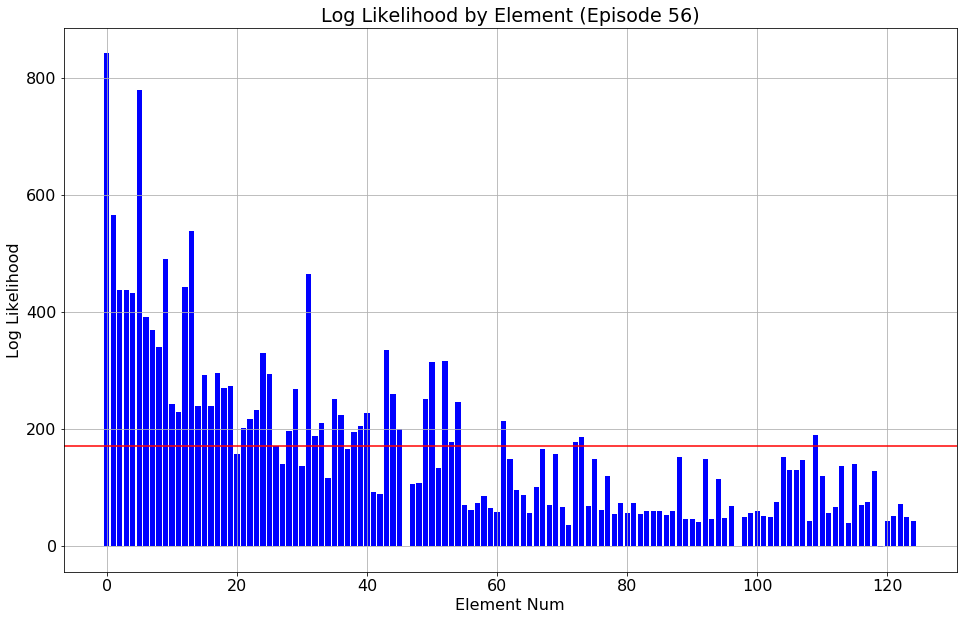

In [97]:
# Bar chart - log likelihood by element
fig, ax = model.plot_bar('log_like', sorted=False)

In [98]:
fig.savefig('../figs/search_known/random/log_like.png', bbox_inches='tight')

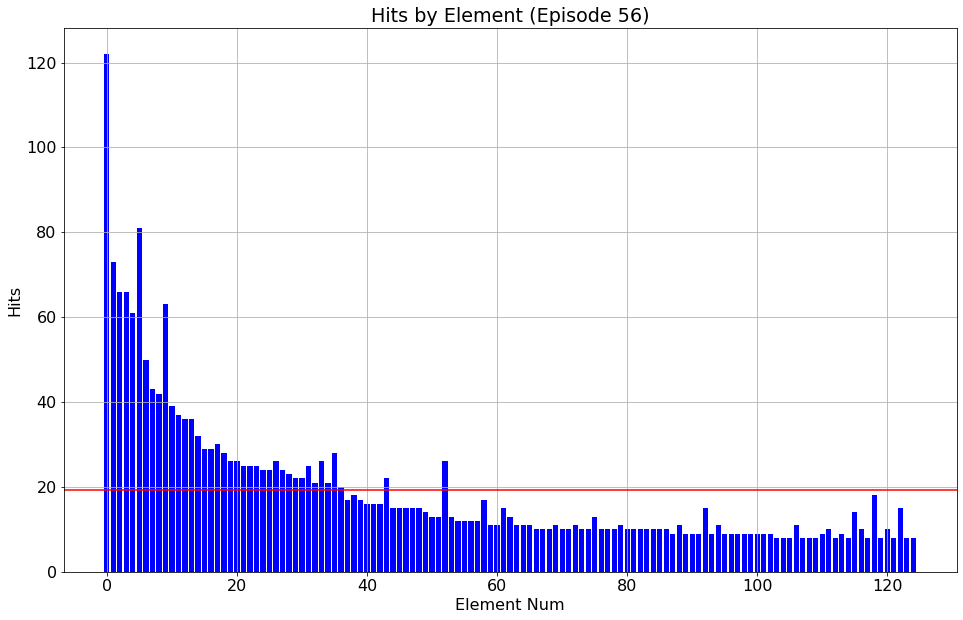

In [99]:
# Bar chart: hits
fig, ax = model.plot_bar('hits', sorted=False)

In [100]:
fig.savefig('../figs/search_known/random/hits.png', bbox_inches='tight')

In [59]:
# # Bar chart: resolution
# fig, ax = model.plot_bar('log_R', sorted=False)

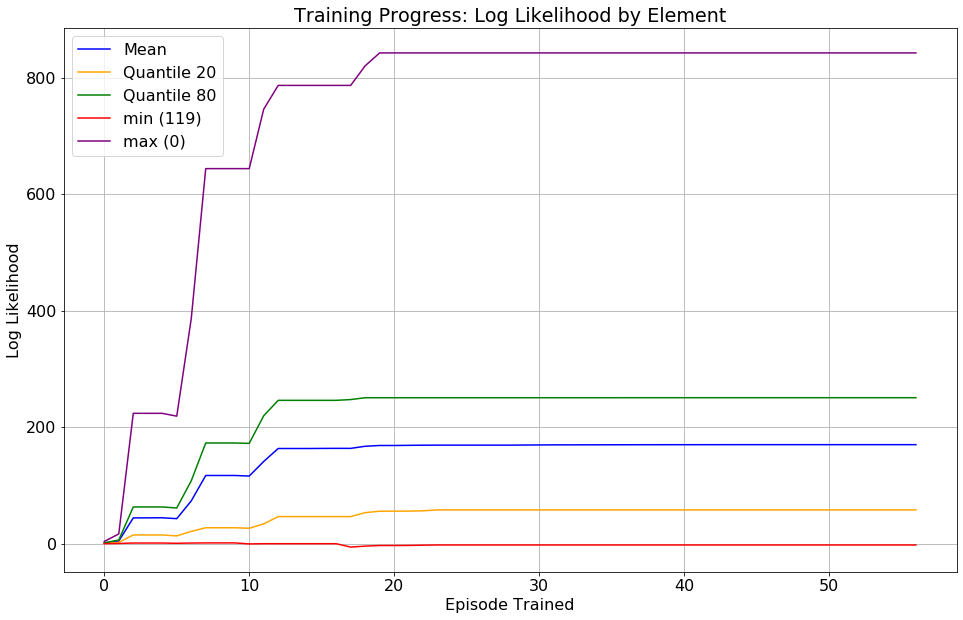

In [60]:
# Learning curve: log likelihood
fig, ax = model.plot_hist('log_like', 'episode')

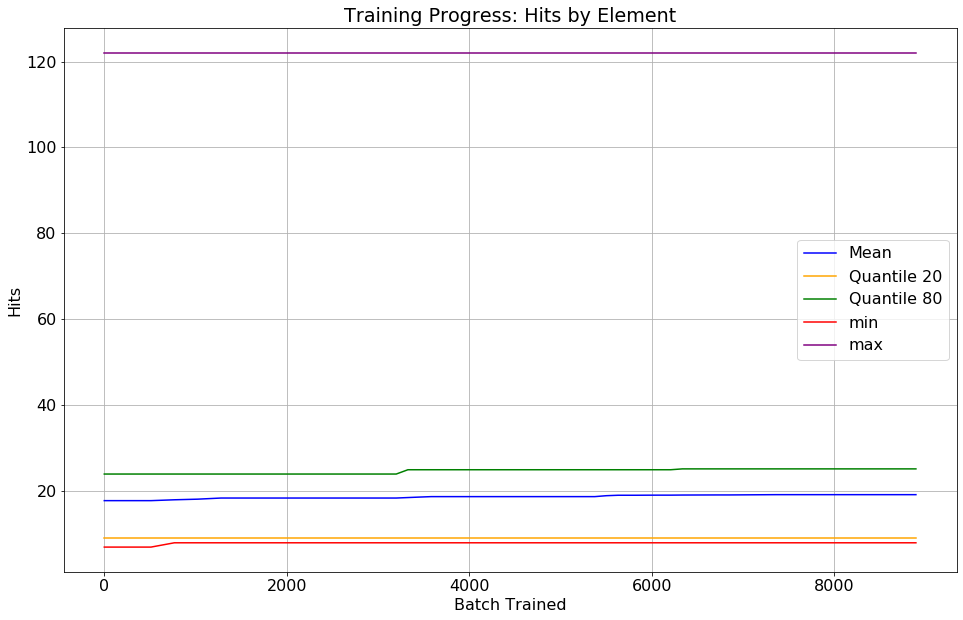

In [61]:
# Learning curve: hits
fig, ax = model.plot_hist('hits')

## Distance vs. Nearest Asteroid for Fitted Elements

In [74]:
# Find nearest asteroid to fitted elements - search on Cartesian distance
elts_fit, elts_near = model.nearest_ast(search_type='cart')

In [75]:
elts_fit

,element_id,a,e,inc,Omega,omega,f,epoch,num_hits,R,...,thresh_deg,thresh_sec,log_like,hits,num_rows_close,H,sigma_mag,nearest_ast_num,nearest_ast_dist,nearest_ast_q_norm
0,132055,3.001259,0.106583,0.176153,5.593913,0.756441,-0.352044,58600.0,121.942749,0.000010,...,0.037118,133.626160,843.028076,122.0,123.0,16.500002,1.0,16144,0.000068,0.010786
1,146842,3.014638,0.103410,0.226416,0.944375,2.602004,-2.829622,58600.0,94.932755,0.000035,...,0.152400,548.639160,565.797485,73.0,179.0,16.500002,1.0,2573,0.000479,0.054085
2,13172,2.574177,0.177445,0.172849,2.846966,2.930934,-5.419372,58600.0,72.979935,0.000034,...,0.087775,315.991272,437.269135,66.0,85.0,16.500002,1.0,26703,0.000569,0.023343
3,167580,3.197130,0.166593,0.129728,0.458809,0.868540,-1.704000,58600.0,65.974518,0.000014,...,0.082713,297.765961,438.052979,66.0,94.0,16.500002,1.0,11205,0.000356,0.018486
4,57218,2.896829,0.044413,0.014003,4.265576,0.151074,2.625728,58600.0,81.650574,0.000043,...,0.223402,804.248352,433.109375,61.0,353.0,16.500002,1.0,459814,0.003643,2.711176
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120,103865,2.751478,0.129651,0.187429,3.997166,3.907550,4.668994,58600.0,11.521851,0.000041,...,0.281648,1013.931641,43.135262,10.0,258.0,16.500002,1.0,152228,0.004455,0.997625
121,6741,2.648119,0.111147,0.149182,0.990966,3.100657,-3.746168,58600.0,11.906599,0.000024,...,0.194224,699.206909,51.820465,8.0,163.0,16.500002,1.0,364406,0.004038,0.575896
122,101616,2.269692,0.157575,0.098144,1.597958,3.080547,-4.575780,58600.0,15.976654,0.000042,...,0.242390,872.604736,72.037140,15.0,189.0,16.500002,1.0,9434,0.003604,2.422516
123,122026,2.325350,0.025995,0.046228,2.160600,4.807646,-0.551645,58600.0,10.807017,0.000028,...,0.253771,913.575867,49.244034,8.0,194.0,16.500002,1.0,57503,0.003997,1.916189


In [80]:
# Review asteroids nearest to the fitted elements
cols = ['element_id', 'log_like', 'hits', 'R_sec', 'thresh_sec', 'nearest_ast_num', 'nearest_ast_dist', 'nearest_ast_q_norm']

# Summary
has_hits = (model.elts_fit.hits >= 8)
is_converged = has_hits
num_converged = np.sum(is_converged)

# Mean on converged
mean_hits = np.mean(model.elts_fit.hits[is_converged])
mean_R_sec = np.mean(model.elts_fit.R_sec[is_converged])
geomean_R_sec = np.exp(np.mean(np.log(model.elts_fit.R_sec[is_converged])))
err_cart_mean = np.mean(model.elts_near_ast.nearest_ast_dist[is_converged])
err_cart_geo = np.exp(np.mean(np.log(model.elts_near_ast.nearest_ast_dist[is_converged])))
err_cov_mean = np.exp(np.mean(np.log(model.elts_near_ast.nearest_ast_q_norm[is_converged])))

# Report
print(f'Good convergence on {num_converged} asteroids.')
print(f'Mean on converged asteroids:')
print(f'Number of hits         : {mean_hits:5.2f}')
print(f'Resolution in arc sec  : {geomean_R_sec:5.2f}')
# print(f'Mean Distance in AU    : {err_cart_mean:5.2e}')
print(f'GeoMean Distance in AU : {err_cart_geo:5.2e}')
print(f'Covariance norm        : {err_cov_mean:5.2e}')

Good convergence on 125 asteroids.
Mean on converged asteroids:
Number of hits         : 19.20
Resolution in arc sec  :  9.29
GeoMean Distance in AU : 2.66e-03
Covariance norm        : 7.28e-01


In [ ]:
# Review good matches
model.elts_fit[cols][is_converged].sort_values(by=['hits', 'R_sec'], ascending=[False, True])

In [ ]:
# # Filter for incomplete convergence
# mask = (elts_fit.log_like > 200) & (elts_fit.R_sec >= 60)
# elts_fit[mask]

## Visualize Error vs. Nearest Asteroid

In [ ]:
# model.elts_near_ast

In [ ]:
model.elts_fit

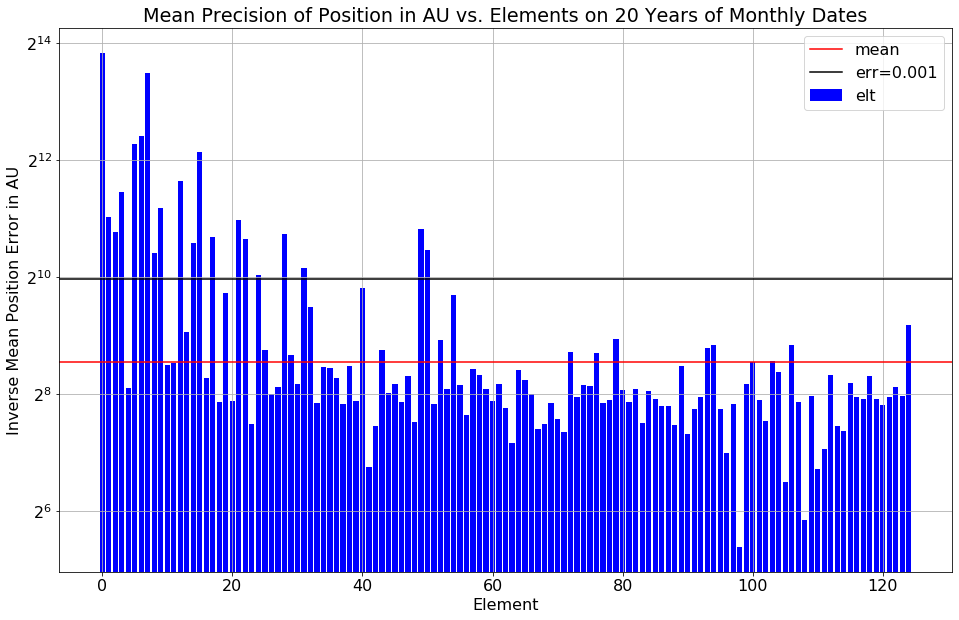

In [106]:
# Plot position error vs. known elements
fig, ax = model.plot_q_error(is_log=True, use_near_ast_dist=True)

In [107]:
fig.savefig('../figs/search_known/random/near_ast_dist.png', bbox_inches='tight')

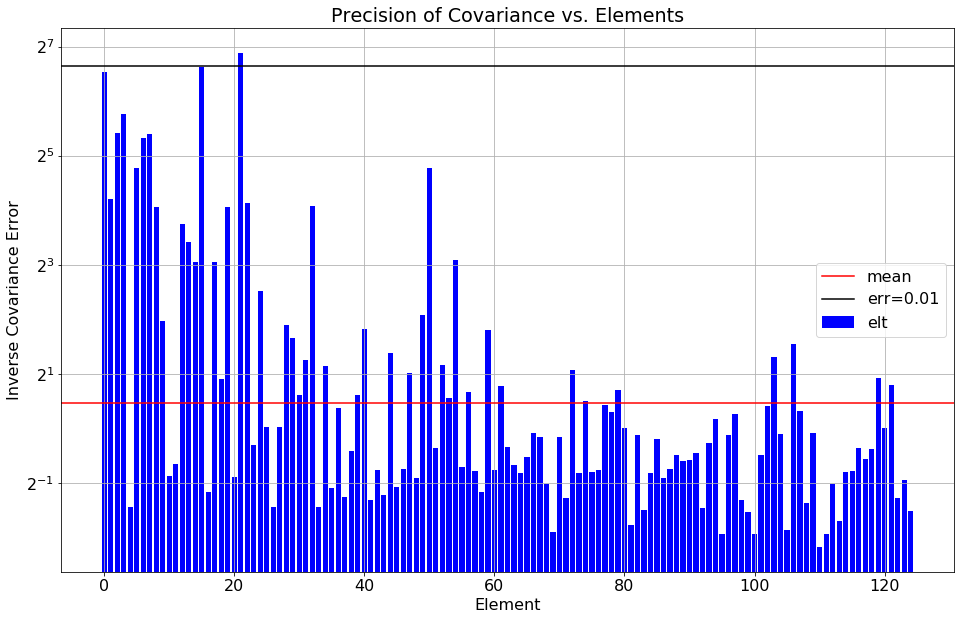

In [108]:
# Plot covariance error vs. known elements
fig, ax = model.plot_q_error(plot_type='cov', is_log=True, use_near_ast_dist=True)

In [109]:
fig.savefig('../figs/search_known/random/near_ast_cov.png', bbox_inches='tight')

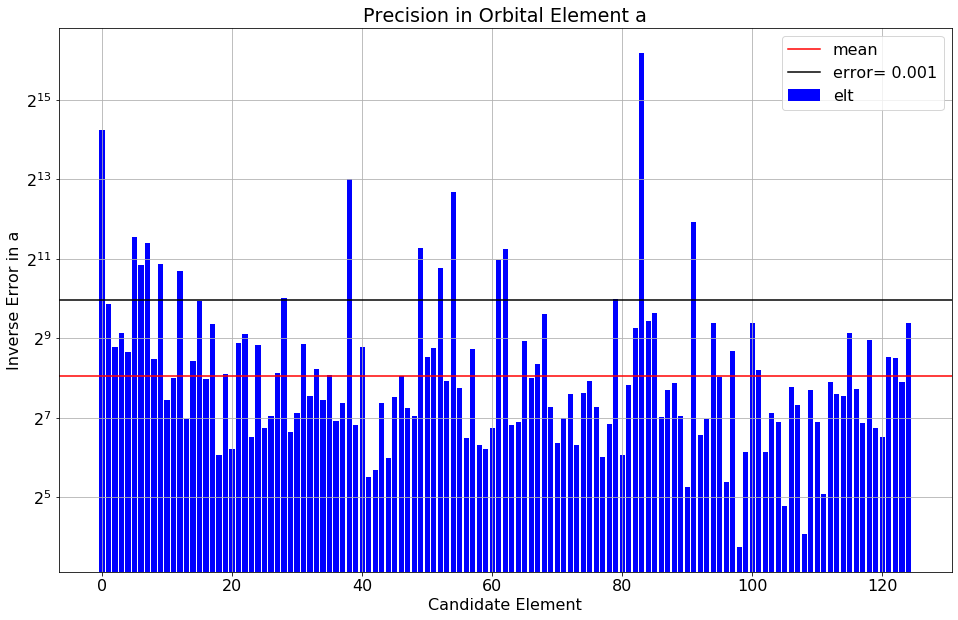

In [110]:
# Plot error in orbital elements
fig, ax = model.plot_elt_error_bar(elt_name='a', is_log=True)

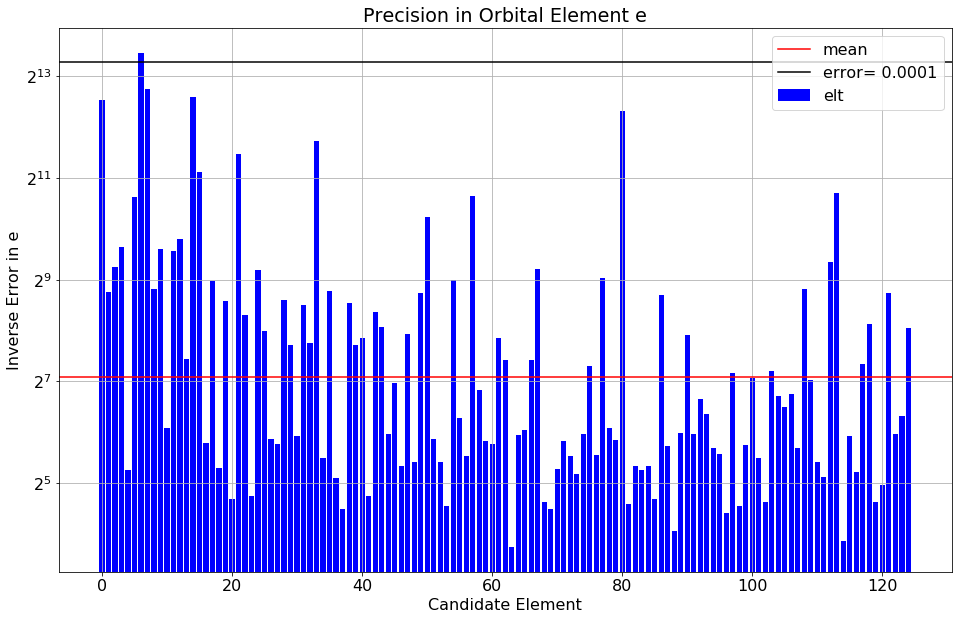

In [111]:
# Plot error in orbital elements
fig, ax = model.plot_elt_error_bar(elt_name='e', is_log=True)